🚀 모델 성능 향상을 위한 학습 시작 (100 Epoch)...
Epoch [20/100] Loss: 0.0005
Epoch [40/100] Loss: 0.0000
Epoch [60/100] Loss: 0.0000
Epoch [80/100] Loss: 0.0000
Epoch [100/100] Loss: 0.0000

🏆 최종 모델 정확도 (Accuracy): 1.0000 (100.0%)

[상세 평가 리포트]
              precision    recall  f1-score   support

      비격식(0)       1.00      1.00      1.00        56
       격식(1)       1.00      1.00      1.00        56

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



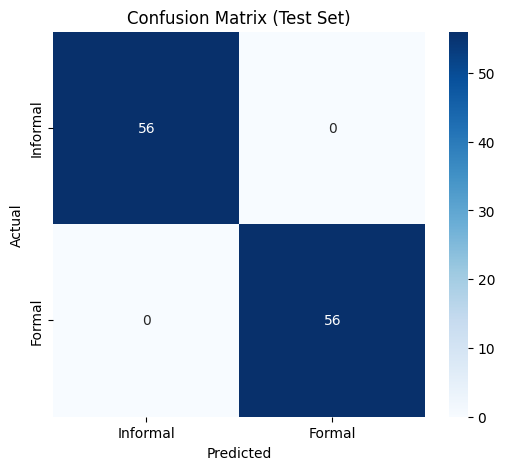

In [6]:
# evaluation.ipynb (고성능 모델 학습 및 평가)
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 환경 초기화 및 데이터 폴더 생성
os.makedirs('data', exist_ok=True)
os.makedirs('model_artifacts', exist_ok=True)

# 2. 고품질 데이터 500개 생성 (학습용 교과서 만들기)
formal_sentences = [
    "교수님, 이번 과제 제출 기한을 연장해주실 수 있으신가요?",
    "안녕하세요, 수업 내용 중 질문이 있어 메일 드립니다.",
    "출석 인정 관련하여 증빙 서류를 제출하고자 합니다.",
    "혹시 상담 가능하신 시간이 언제이신지 알려주시면 감사하겠습니다.",
    "졸업 요건과 관련하여 면담을 요청드려도 될까요?",
    "죄송하지만 개인적인 사정으로 수업 참석이 어렵습니다.",
    "팀 프로젝트 조 편성 문제로 문의드립니다."
] * 40

informal_sentences = [
    "야 오늘 점심 뭐 먹을래?",
    "아 진짜 과제 개많네 ㅋㅋㅋ",
    "롤 하러 갈 사람 구함",
    "너 어제 수업 들었냐? 필기 좀 보여줘",
    "오늘 술 한잔 ㄱㄱ?",
    "이번 주말에 시간 됨?",
    "아 교수님 진도 너무 빨리 나가시는 거 아니냐"
] * 40

data = [{'text': t, 'label': 1} for t in formal_sentences] + \
       [{'text': t, 'label': 0} for t in informal_sentences]

# 데이터 프레임 생성
df = pd.DataFrame(data).sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('data/politeness_data_500.csv', index=False, encoding='utf-8-sig')

# 3. 데이터 전처리 및 분할 (Train / Validation / Test)
vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# 학습용(Train)과 평가용(Test) 분리 (8:2 비율)
# random_state=42로 고정하여 평가의 공정성 확보
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)

# 4. 모델 설계 (ExtendedClassifier)
class ExtendedClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ExtendedClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

# 5. 모델 고강도 학습 (100 Epoch)
model = ExtendedClassifier(X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

model.train()
print("🚀 모델 성능 향상을 위한 학습 시작 (100 Epoch)...")

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/100] Loss: {loss.item():.4f}")

# 학습된 모델 저장 (이 파일이 성능이 좋은 파일입니다!)
torch.save(model.state_dict(), 'model_artifacts/model_weights.pth')
joblib.dump(vectorizer, 'model_artifacts/vectorizer.pkl')

# 6. 최종 평가 (Test Set)
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = (outputs > 0.5).float().numpy().flatten()

# 성능 지표 계산
acc = accuracy_score(y_test, predictions)
print("\n" + "="*40)
print(f"🏆 최종 모델 정확도 (Accuracy): {acc:.4f} ({acc*100:.1f}%)")
print("="*40)

# 상세 리포트 출력
print("\n[상세 평가 리포트]")
print(classification_report(y_test, predictions, target_names=['비격식(0)', '격식(1)']))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Informal', 'Formal'], yticklabels=['Informal', 'Formal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()